# ATT ABP & ABR Questions

by `Xiaoli Qiu`

created: `2022-01-17`

Jira: https://clearlink.atlassian.net/browse/ONE-7860.

This notebook aims at answering the questions described in the Jira ticket. See the ticket for details. 

Overflow abandon codes:
- Prequeue: [490, 491, 493, 494, 495, 626, 700, 704].
- Queue: [322, 637, 638, 639, 640, 641, 699]. 

Note: Vivint: 699 (queue) & 700 (non-queue); Updater: 704. Other abandon codes: IBEX (322 & 626 being default/everything else). <br>

__HOO:__ (all MDT)
- VIVINT: 7AM-10PM M-F, 8AM-10PM Sat, Closed on Sunday.
- UPDATER: 5AM-11PM M-F, 5AM-9PM Sat/Sun
- IBEX: 5AM-9PM M-Sat, 8AM-6PM Sun

## Contents
- <a href ='#functions'> Functions </a>
- <a href='#q_overflowcalls'> Analysis on the Calls That Were Supposed to Be Overflowed </a>
- <a href ='#consent_analysis'> Analysis on Consent  </a>
- <a href='#tldr'> TL;DR  </a>


In [1]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-01-17 09:36:23.183305


In [2]:
import pandas as pd
import numpy as np 

In [24]:
from scipy.stats import chi2_contingency 

In [33]:
import matplotlib.pyplot as plt  
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

In [5]:
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_dark"

In [6]:
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [7]:
# Set universal font size
plt.rcParams.update({'font.size': 20})

# plt.rc('figure', figsize=(20, 6))

<a id='functions'> </a>

# Functions

In [25]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
#                 chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [103]:
def call_conclusion_clean(df):
    """
    Change the call conclusion for overflowed calls. 
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    
    df = df.copy(deep=True)
    # pre-queue overflow (IVR, ABP)
    df['prequeue_overflow'] = '0'
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([490, 491, 493, 494, 495, 626])), 'IBEX', df['prequeue_overflow'])
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([700])), 'Vivint', df['prequeue_overflow'])
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([704])), 'Updater', df['prequeue_overflow'])
    
    # queue overflow
    df['queue_overflow'] = '0'
    df['queue_overflow'] = np.where((df['queue_opp']==1)&(df['abandon_code'].isin([322, 637, 638, 639, 640, 641])), 'IBEX', df['queue_overflow'])
    df['queue_overflow'] = np.where((df['queue_opp']==1)&(df['abandon_code'].isin([699])), 'Vivint', df['queue_overflow'])
    
    df.loc[(df['queue_opp']==0)&(df['prequeue_overflow']!='0'), 'call_conclusion'] = 'prequeue_overflow'
    df.loc[(df['queue_opp']==1)&(df['queue_overflow']!='0'), 'call_conclusion'] = 'queue_overflow'
    
    return df

In [472]:
def check_hoo_etc(df):
    """
    Function to check if in HOO, not containing a route_id of 781. 
    :param df: dataframe containing calls that were supposed to be overflowed
    :
    """
    # Calls that were supposed to be overflowed to VIVINT:  # TODO: Review the logic
    # VIVINT is closed on Sunday, so exclude Sunday
    df_vv_set = df[(df['result_overflow'].str.contains('VIVINT')) & (df['date_prequeue_start'].dt.dayofweek!=6)].copy(deep=True)
    # For Sat, VIVINT HOO: 8AM-10PM, there should not be any calls
    # For M-F, 7AM-10PM, there should not be any calls
    df_vv = df_vv_set[(df_vv_set['date_prequeue_start'].dt.dayofweek==5) & (df_vv_set['date_prequeue_start'].dt.hour.between(8,21))
                      | ( 
                          (df_vv_set['date_prequeue_start'].dt.dayofweek<=4) & (df_vv_set['date_prequeue_start'].dt.hour.between(7,21))
                      )
                     ]
    
#     if len(df_vv) > 0:
#         print('These calls were supposed to be overflowed to VIVINT: ', df_vv)
        
    # calls that were supposed to be overflowed to IBEX:
    # For Sun: IBEX HOO: 8AM-6PM
    # For M-Sat: 5AM-9PM
    df_ibex_set = df[df['result_overflow'].str.contains('IBEX')].copy(deep=True)
    df_ibex = df_ibex_set[((df_ibex_set['date_prequeue_start'].dt.dayofweek==6) & (df_ibex_set['date_prequeue_start'].dt.hour.between(8,17))) 
                          | (
                              (df_ibex_set['date_prequeue_start'].dt.dayofweek<=5) & (df_ibex_set['date_prequeue_start'].dt.hour.between(5,20))
                          )
                         ]
                 
#     if len(df_ibex) > 0:
#         print('These calls were supposed to be overflowed to IBEX: ', df_ibex)
        
    return tuple([df_vv, df_ibex])

In [8]:
import psycopg2

In [478]:
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

In [105]:
get_data = """
SELECT DISTINCT cdal.contact_id,
       case
           when is_queue_opp = true and call_purpose in ('Sales', 'External Transfer', 'Internal Transfer') then 1
           else 0 end                                                              as queue_opp,
       cd.brand_marketed,
       cd.brand_skilled,
       cd.skill, cd.skill_name,
       cd.date_sort_prequeue_start,
       cdal.intent_lookup_flag,
       cdal.consent_flag,
       cdal.max_speed_qual,
       json_extract_path_text(cdcda.attributes_post, 'marketgroup') AS marketing_tier_abp,
       cdcda.result_priority                                        AS abp_priority,
       cdcda.result_overflow,
       cdcda.agents_available,
       cdcda.calls_in_queue,
       cd.date_prequeue_start,
       cd.date_prequeue_end,
       cd.date_queue_start,
       cd.date_queue_end,
       cd.date_call_start,
       cd.date_call_end,
       cd.handle_time,
       cd.abandon_code,
       cd.abandon_code_name,
       cd.call_conclusion,
       cd.promo_code, cd.marketing_tier, cd.campaign, cd.channel,
       cdal.is_converted
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.call_detail cd ON cd.contact_id = cdal.contact_id
         LEFT JOIN vwst_ph_db.call_detail_call_detail_abp cdcda ON cdal.contact_id = cdcda.contact_id
WHERE cd.brand_skilled = 'ATT'
  AND date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'  -- '2021-09-26' AND '2021-12-21'
  AND cd.call_type = 'I'
  AND cd.is_queue_opp = True
  and cd.call_purpose in ('Sales');
"""

In [229]:
df = pd.read_sql_query(get_data.format(start_date= '2021-09-26', end_date= '2021-12-21'), con)

# test for Cari
# df = pd.read_sql_query(get_data.format(start_date= '2022-01-21', end_date= '2022-02-01'), con)

In [107]:
# df.to_pickle('ATT_ABP_ABR_Qs_Sep26ToDec21_2021.pkl')

In [479]:
# df = pd.read_pickle('ATT_ABP_ABR_Qs_Sep26ToDec21_2021.pkl')

In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44651 entries, 0 to 44650
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   contact_id                44651 non-null  object        
 1   queue_opp                 44651 non-null  int64         
 2   brand_marketed            44651 non-null  object        
 3   brand_skilled             44651 non-null  object        
 4   skill                     44651 non-null  int64         
 5   skill_name                44651 non-null  object        
 6   date_sort_prequeue_start  44651 non-null  object        
 7   intent_lookup_flag        44651 non-null  int64         
 8   consent_flag              44651 non-null  int64         
 9   max_speed_qual            44651 non-null  object        
 10  marketing_tier_abp        44644 non-null  object        
 11  abp_priority              44644 non-null  float64       
 12  result_overflow   

In [481]:
df

contact_id  queue_opp brand_marketed brand_skilled   skill  \
0      167055990148          1            HSI           ATT  293711   
1      167057644482          1            ATT           ATT  293711   
2      167058411546          1            ATT           ATT  293711   
3      167239570870          1            ATT           ATT  293711   
4      167241486642          1            ATT           ATT  293711   
...             ...        ...            ...           ...     ...   
44646  167972291617          1            MSO           ATT  293711   
44647  168375368526          1            ATT           ATT  293711   
44648  193190330738          1            ATT           ATT  293711   
44649  193623993829          1            ATT           ATT  293711   
44650  193624000582          1           REVW           ATT  293711   

                    skill_name date_sort_prequeue_start  intent_lookup_flag  \
0      AT&T - Inbound - SATMAP               2021-10-02                   2   
1      AT&T - Inbound - SATMAP               2021-10-04                   1   
2      AT&T - Inbound - SATMAP               2021-10-04                   1   
3      AT&T - Inbound - SATMAP               2021-10-06                   1   
4      AT&T - Inbound - SATMAP               2021-10-08                   1   
...                        ...                      ...                 ...   
44646  AT&T - Inbound - SATMAP               2021-10-26                   2   
44647  AT&T - Inbound - SATMAP               2021-11-04                   1   
44648  AT&T - Inbound - SATMAP               2021-11-23                   1   
44649  AT&T - Inbound - SATMAP               2021-12-07                   1   
44650  AT&T - Inbound - SATMAP               2021-12-07                   1   

       consent_flag max_speed_qual  ...       date_call_end  handle_time  \
0                 1             75  ...                 NaT          NaN   
1                 1             NA  ...                 NaT          NaN   
2                 1             NA  ... 2021-10-04 16:41:34       1148.0   
3                 1             NA  ... 2021-10-06 18:08:59       3208.0   
4                 1             NA  ... 2021-10-08 08:26:12       2089.0   
...             ...            ...  ...                 ...          ...   
44646             1           1000  ... 2021-10-26 09:41:03        658.0   
44647             1             NA  ... 2021-11-04 08:12:58        243.0   
44648             1             NA  ...                 NaT          NaN   
44649             0             NA  ... 2021-12-07 09:55:00       3546.0   
44650             0             NA  ...                 NaT          NaN   

      abandon_code           abandon_code_name   call_conclusion promo_code  \
0                4           Abandoned - Queue         Abandoned      88464   
1              699  Transferred to: Vivint CPC  Inbound Overflow      98612   
2                1               Call Answered          Answered      94857   
3                1               Call Answered          Answered      98396   
4                1               Call Answered          Answered      98411   
...            ...                         ...               ...        ...   
44646            1               Call Answered          Answered     156754   
44647            1               Call Answered          Answered      94783   
44648            4           Abandoned - Queue         Abandoned      94841   
44649            1               Call Answered          Answered      75344   
44650          699  Transferred to: Vivint CPC  Inbound Overflow     102942   

           marketing_tier                                  campaign  \
0      Tier 3 CenturyLink  HSI - SEO - /Providers and Provider Type   
1                    MISC                Bing PPC -  AT&T Unmanaged   
2                    MISC               Google PPC - AT&T Unmanaged   
3                    MISC              Google PPC - AT&T Mana

In [482]:
df['contact_id'].nunique() == len(df)

False

In [483]:
df[df.duplicated(subset=['contact_id'])]['contact_id'].unique()

array(['166865274362', '194163030674', '168775383653', '168274039478',
       '167448750444', '168571184052', '166951992509', '193192400272',
       '193519635061', '168070476952', '168376110566', '168875840920',
       '168070741580', '166952291020'], dtype=object)

In [484]:
df_nodup = df.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'],keep="first")

In [485]:
df_nodup['contact_id'].nunique() == len(df_nodup)

True

In [486]:
# Make sure handle time is not negative
df_nodup[(df_nodup['call_conclusion']=='Answered')]['handle_time'].describe()

count    40243.000000
mean       971.835624
std        853.882707
min          1.000000
25%        352.000000
50%        761.000000
75%       1357.000000
max      13048.000000
Name: handle_time, dtype: float64

In [487]:
# df_nodup['handle_time'] = (df_nodup['date_call_end'] - df_nodup['date_call_start']).dt.total_seconds()

<a id='q_overflowcalls'> </a>

# Analysis on the Calls That Were Supposed to Be Overflowed 

Look at the calls that were supposed to be overflowed but made it into our queue.

In [488]:
df_1 = call_conclusion_clean(df_nodup)

In [489]:
df_1[df_1['result_overflow']!='NA']['call_conclusion'].value_counts()
# These calls would've been overflowed

Answered          5390
queue_overflow     659
Abandoned          501
Name: call_conclusion, dtype: int64

In [301]:
get_ivr_records = """
SELECT DISTINCT cd.contact_id,
 LISTAGG(lcr.id, ',') as path_ids,
 LISTAGG(lcr.description, ',') as route_id_names,
 LISTAGG(cdr.route_order, ',') AS route_orders
 FROM data_warehouse.call_detail cd
 JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cdr.contact_id = cd.contact_id
 LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lcr ON cdr.lookup_cd_ivr_route_ids_id = lcr.id
 WHERE cd.contact_id IN {c_list}
 GROUP BY cd.contact_id
 ORDER BY cd.contact_id;
 """

Get all of their route_ids

In [490]:
df_check_needed = df_1[~df_1['result_overflow'].isin(['NA', 'UPDATER-INTERNAL', None])] # 'UPDATER-IBEX-GEN' should be included?
ci_list = df_check_needed['contact_id'].to_list()
c_list = "({contact_id})".format(contact_id=', '.join(map(str, ["'{x}'".format(x=x) for x in ci_list])))

In [491]:
df_ovans = pd.read_sql_query(get_ivr_records.format(c_list=c_list), con)

In [411]:
# df_ovans[~df_ovans['path_ids'].str.contains('781')]['contact_id'].unique()
# these are the contact_ids that actually needs to be checked

In [492]:
df_check_needed_actual = df_check_needed[df_check_needed['contact_id'].isin(map(str, df_ovans[~df_ovans['path_ids'].str.contains('781')]['contact_id'].unique()))]

In [494]:
df_vv, df_ibex = check_hoo_etc(df_check_needed_actual)

In [495]:
df_vv[['contact_id', 'call_conclusion', 'date_prequeue_start', 'result_overflow']] #['date_prequeue_start'].dt.hour

contact_id call_conclusion date_prequeue_start result_overflow
26483  168876139741       Abandoned 2021-11-15 21:59:55          VIVINT
32445  167449352335       Abandoned 2021-10-13 21:58:48          VIVINT
19917  167349587197       Abandoned 2021-10-08 21:59:51  UPDATER-VIVINT
23907  193407381754       Abandoned 2021-12-01 21:59:33          VIVINT

In [496]:
df_ibex[['contact_id', 'call_conclusion', 'date_prequeue_start', 'result_overflow']]

contact_id call_conclusion date_prequeue_start result_overflow
26682  167055534668        Answered 2021-10-01 20:55:39    UPDATER-IBEX
32153  166866474397        Answered 2021-09-29 20:58:14    UPDATER-IBEX
4527   194060768961        Answered 2021-12-16 20:59:56    UPDATER-IBEX
13064  168373573644        Answered 2021-11-02 20:58:03            IBEX

All these exceptions are very closed to the time of closure of VIVNT/IBEX. 

<a id='summary_calls'> </a>
## Summary for those calls
The calls that have an overflow variable assigned but got into our queue are either one of the following:
 - Zip code isn't an Xfinity area ('UPDATER-INTERNAL')
 - The call has: _Route ID 781 - TV Only Flag_, which skips the custom priority overflow and will just go straight to queue.
 - IBEX was closed (or very closed to be closed) ('UPDATER-IBEX', 'IBEX')
 - VIVINT was closed (or very closed to be closed) ('UPDATER-VIVINT', 'VIVINT')

<a id ='consent_analysis'> </a>
# Analysis on Consent

In [137]:
[resultant_chi, resultant_p] = chi_square_test(df_1[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_converted']])

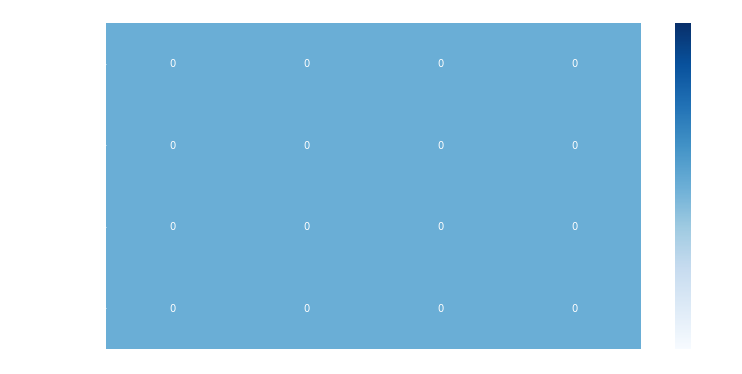

In [138]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

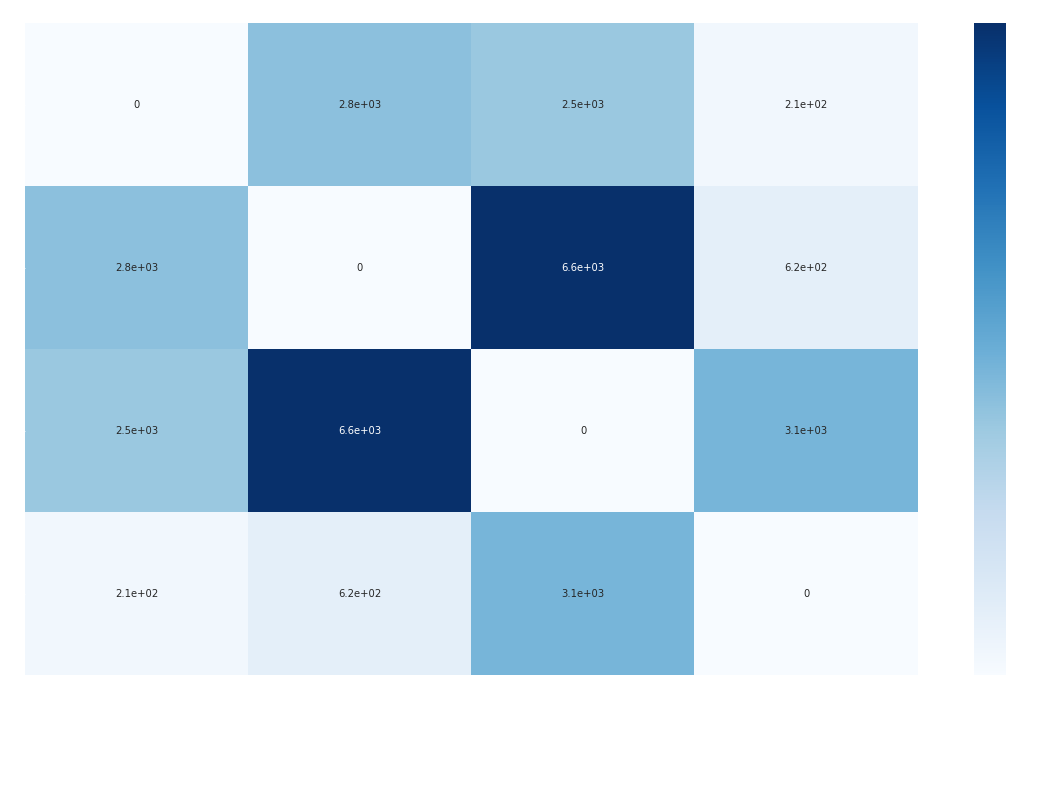

In [139]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

## Closer look at the contigency table

In [225]:
contingency_intent = pd.crosstab(df_1['intent_lookup_flag'], df_1['is_converted'])
contingency_intent
# observed counts

is_converted            0     1
intent_lookup_flag             
0                    2165   676
1                   20733  9657
2                    8500  2906

In [226]:
contingency_intent.loc['column_sum', :] = contingency_intent.sum(axis=0)
# row sum
contingency_intent.loc[:, 'row_sum'] = contingency_intent.sum(axis=1)
contingency_intent

is_converted              0        1  row_sum
intent_lookup_flag                           
0                    2165.0    676.0   2841.0
1                   20733.0   9657.0  30390.0
2                    8500.0   2906.0  11406.0
column_sum          31398.0  13239.0  44637.0

In [187]:
c_intent, p_intent, _, expected_intent = chi2_contingency(contingency_intent)
pd.DataFrame(expected_intent, columns=['0', '1'], index=contingency_intent.index)
# Expected counts

0            1
intent_lookup_flag                           
0                    1998.380671   842.619329
1                   21376.553532  9013.446468
2                    8023.065797  3382.934203

In [188]:
pd.DataFrame((np.asarray(contingency_intent)/expected_intent), columns=['0', '1'], index=contingency_intent.index)
# Ratios between observed values and the expected values (observed/expected)

0         1
intent_lookup_flag                    
0                   1.083377  0.802260
1                   0.969894  1.071399
2                   1.059445  0.859018

In [189]:
pd.DataFrame(((np.asarray(contingency_intent) - expected_intent)**2/expected_intent), columns=['0', '1'], index=contingency_intent.index)
# Individual components in chi value

0          1
intent_lookup_flag                      
0                   13.892249  32.947263
1                   19.374552  45.949255
2                   28.351535  67.239331

In [143]:
c_intent

207.7541852271849

<a id='intent'> </a>

__Observations:__

The abserved values are not far away from the expected, hence, chi-square value is low. 

In [146]:
contingency_consent = pd.crosstab(df_1['consent_flag'], df_1['is_converted'])
contingency_consent
# observed counts

is_converted      0      1
consent_flag              
0              8570   2154
1             22828  11085

In [190]:
c_consent, p_consent, _, expected_consent = chi2_contingency(contingency_consent)
pd.DataFrame(expected_consent, columns=['0', '1'], index=contingency_consent.index)
# Expected counts

0             1
consent_flag                            
0              7543.341891   3180.658109
1             23854.658109  10058.341891

In [192]:
pd.DataFrame((np.asarray(contingency_consent)/expected_consent), columns=['0', '1'], index=contingency_consent.index)
# Ratios between observed values and the expected values (observed/expected)

0         1
consent_flag                    
0             1.136101  0.677218
1             0.956962  1.102070

In [191]:
pd.DataFrame(((np.asarray(contingency_consent) - expected_consent)**2/expected_consent), columns=['0', '1'], index=contingency_consent.index)
# Individual components in chi-value

0           1
consent_flag                        
0             139.729431  331.386410
1              44.185369  104.791315

In [150]:
c_consent

619.4886810550032

__Observations:__

Compared to intent-is_converted, the observed values (for consent-is_converted) are further away from the from the expected. 

## Look at a shorter period

In [155]:
df_2 = df_1[df_1['date_prequeue_start'].between('2021-12-01 06:00:00', '2021-12-21 22:00:00')]

In [156]:
[resultant_chi_2, resultant_p_2] = chi_square_test(df_2[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_converted']])

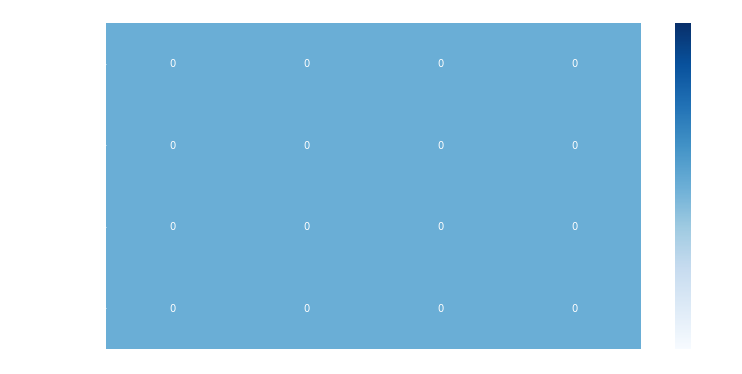

In [157]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_2,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

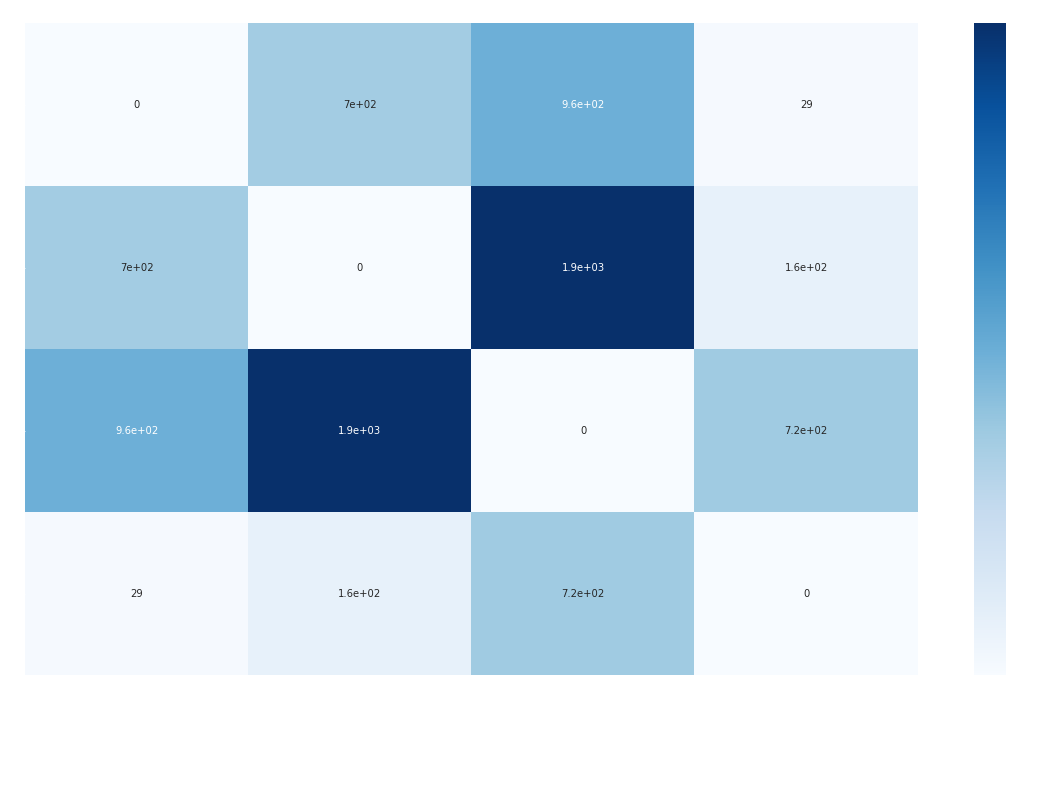

In [158]:
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_2, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

With a shorter period (2021-12-01 - 2021-12-21), intent seems to be even less significant. 

In [159]:
contingency_intent_2 = pd.crosstab(df_2['intent_lookup_flag'], df_2['is_converted'])
contingency_intent_2

is_converted           0     1
intent_lookup_flag            
0                    484   177
1                   4579  2209
2                   1754   658

In [184]:
# Chi-square test of independence.
c_intent_2, p_intent_2, _, expected_intent_2 = chi2_contingency(contingency_intent_2)
pd.DataFrame(expected_intent_2, columns=['0', '1'], index=contingency_intent_2.index)

0            1
intent_lookup_flag                          
0                    456.955380   204.044620
1                   4692.606835  2095.393165
2                   1667.437785   744.562215

In [185]:
pd.DataFrame((np.asarray(contingency_intent_2)/expected_intent_2), columns=['0', '1'], index=contingency_intent_2.index)
# Ratios between observed values and the expected values (observed/expected)

0         1
intent_lookup_flag                    
0                   1.059184  0.867457
1                   0.975790  1.054217
2                   1.051913  0.883741

In [186]:
pd.DataFrame(((np.asarray(contingency_intent_2) - expected_intent_2)**2/expected_intent_2), columns=['0', '1'], index=contingency_intent_2.index)
# Individual components in chi value

0          1
intent_lookup_flag                     
0                   1.600619   3.584566
1                   2.750393   6.159471
2                   4.493731  10.063655

In [163]:
c_intent_2

28.65243497018448

In [165]:
contingency_consent_2 = pd.crosstab(df_2['consent_flag'], df_2['is_converted'])
contingency_consent_2

is_converted     0     1
consent_flag            
0             1858   474
1             4959  2570

In [179]:
c_consent_2, p_consent_2, _, expected_consent_2 = chi2_contingency(contingency_consent_2)
pd.DataFrame(expected_consent_2, columns=['0', '1'], index=contingency_consent_2.index)

0            1
consent_flag                          
0             1612.133049   719.866951
1             5204.866951  2324.133049

In [183]:
pd.DataFrame((np.asarray(contingency_consent_2)/expected_consent_2), columns=['0', '1'], index=contingency_consent_2.index)
# Ratios between observed values and the expected values (observed/expected)

0         1
consent_flag                    
0             1.152510  0.658455
1             0.952762  1.105789

In [181]:
pd.DataFrame(((np.asarray(contingency_consent_2) - expected_consent_2)**2/expected_consent_2), columns=['0', '1'], index=contingency_consent_2.index)
# Individual components in chi-value

0          1
consent_flag                      
0             37.497251  83.974625
1             11.614237  26.009938

In [169]:
c_consent_2

158.44962739839943

## A Look at max_speed vs is_converted

In [172]:
contingency_speed = pd.crosstab(df_1['max_speed_qual'], df_1['is_converted'])
contingency_speed

is_converted        0     1
max_speed_qual             
0                 215    41
1                  14     3
10                  9     1
100               697   446
1000             4256  4440
18                 12     5
2                   6     1
25               1372   760
5                  11     1
50               2288  1297
500                 1     0
5000               46    36
75                713   400
NA              21758  5808

In [176]:
c_speed, p_speed, _, expected_speed = chi2_contingency(contingency_speed)
pd.DataFrame(expected_speed, index=contingency_speed.index)

0            1
max_speed_qual                           
0                 180.072317    75.927683
1                  11.957927     5.042073
10                  7.034075     2.965925
100               803.994758   339.005242
1000             6116.831507  2579.168493
18                 11.957927     5.042073
2                   4.923852     2.076148
25               1499.664762   632.335238
5                   8.440890     3.559110
50               2521.715841  1063.284159
500                 0.703407     0.296593
5000               57.679414    24.320586
75                782.892533   330.107467
NA              19390.130788  8175.869212

In [177]:
pd.DataFrame(np.asarray(contingency_speed)/expected_speed, columns=['0', '1'], index=contingency_speed.index)

0         1
max_speed_qual                    
0               1.193965  0.539988
1               1.170771  0.594993
10              1.279486  0.337163
100             0.866921  1.315614
1000            0.695785  1.721485
18              1.003518  0.991656
2               1.218558  0.481661
25              0.914871  1.201894
5               1.303180  0.280969
50              0.907319  1.219806
500             1.421651  0.000000
5000            0.797512  1.480227
75              0.910725  1.211727
NA              1.122117  0.710383

In [227]:
pd.DataFrame(((np.asarray(contingency_speed) - expected_speed)**2/expected_speed), columns=['0', '1'], index=contingency_speed.index)
# Individual components in chi-value

0            1
max_speed_qual                         
0                 6.774740    16.067171
1                 0.348728     0.827053
10                0.549448     1.303088
100              14.238747    33.769030
1000            566.092739  1342.562112
18                0.000148     0.000351
2                 0.235201     0.557809
25               10.867957    25.774764
5                 0.775871     1.840079
50               21.661082    51.372057
500               0.125059     0.296593
5000              2.364946     5.608776
75                6.239638    14.798109
NA              289.157647   685.774743

__Observations:__

Compared to both intent-is_converted and consent-is_converted, the observed values (for max_speed_qual-is_converted) are much further away from the from the expected. 

Speed 1000 & 50 & 100 are doing well, 25 is not bad either. 

<a id ='tldr'> </a>
# TL;DR

- Nothing is broken on Telephony side, senarios are listed [here](#summary_calls).
- ATT customers seem to select intent randomly, see the analysis [here](#intent) and above. 